In [ ]:
import os

data_dir = '../data/Rice_Image_Dataset/'

  # List the contents to verify
if os.path.exists(data_dir):
    print(f"Data directory found: {data_dir}")
    print("Contents:", os.listdir(data_dir))
else:
    print(f"Error: Data directory not found at {data_dir}")

Data directory found: ../data/Rice_Image_Dataset/
Contents: ['Arborio', 'Basmati', 'Ipsala', 'Jasmine', 'Karacadag', 'Rice_Citation_Request.txt', 'S0168169921003021.pdf']


In [ ]:
import torch
import torchvision
from torchvision import transforms, datasets
from torch.utils.data import DataLoader

# Using 70 percentage of GPU memory
torch.cuda.set_per_process_memory_fraction(0.7)

# Define image dimensions and batch size
IMG_HEIGHT = 128
IMG_WIDTH = 128
BATCH_SIZE = 32

# Note the order: Resize/ToTensor first, then augmentations.
# Training transforms
train_transforms = transforms.Compose([
    transforms.Resize((IMG_HEIGHT, IMG_WIDTH)),
    transforms.RandomRotation(20),
    transforms.RandomResizedCrop(size=(IMG_HEIGHT, IMG_WIDTH), scale=(0.8, 1.0)), # A common augmentation
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(), # Converts PIL Image to PyTorch Tensor and scales to [0,1]
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # ImageNet normalization (common practice)
])
# Validation transforms (only resize and normalize)
val_transforms = transforms.Compose([
    transforms.Resize((IMG_HEIGHT, IMG_WIDTH)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
# Load datasets
full_dataset = datasets.ImageFolder(data_dir)
# Split into training and validation sets
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(full_dataset, [train_size, val_size])
# Apply transforms to the respective datasets AFTER splitting (important for random_split)
train_dataset.dataset.transform = train_transforms
val_dataset.dataset.transform = val_transforms
# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
# Get class names
class_names = full_dataset.classes
print("Class Names:", class_names)
num_classes = len(class_names)
print("Number of Classes:", num_classes)

Class Names: ['Arborio', 'Basmati', 'Ipsala', 'Jasmine', 'Karacadag']
Number of Classes: 5


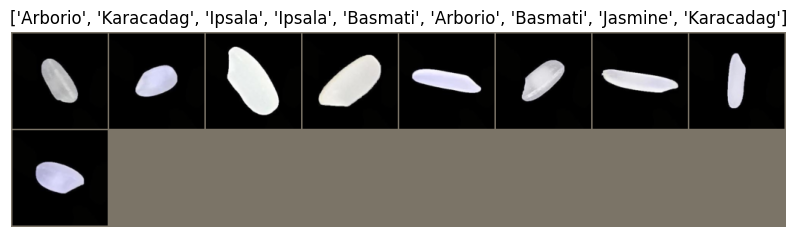

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# Helper function to unnormalize and show image
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean # Unnormalize
    inp = np.clip(inp, 0, 1) # Clip values to [0,1]
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.axis('off')

# Get a batch of training data
images, labels = next(iter(train_loader))

# Make a grid from batch
out = torchvision.utils.make_grid(images[:9])

plt.figure(figsize=(10, 10))
imshow(out, title=[class_names[x] for x in labels[:9]])
plt.show()

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
      def __init__(self, num_classes):
          super(SimpleCNN, self).__init__()
          self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
          self.bn1 = nn.BatchNorm2d(32)
          self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

          self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
          self.bn2 = nn.BatchNorm2d(64)

          self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
          self.bn3 = nn.BatchNorm2d(128)

          # Calculate flattened size: (IMG_HEIGHT / 8) * (IMG_WIDTH / 8) * 128
          # Example for 128x128: 128 / 2 / 2 / 2 = 16. So 16*16*128
          self.fc1 = nn.Linear(16 * 16 * 128, 128) # Adjust this based on your IMG_HEIGHT/WIDTH
          self.dropout = nn.Dropout(0.5)
          self.fc2 = nn.Linear(128, num_classes)

      def forward(self, x):
          x = self.pool(F.relu(self.bn1(self.conv1(x))))
          x = self.pool(F.relu(self.bn2(self.conv2(x))))
          x = self.pool(F.relu(self.bn3(self.conv3(x))))

          x = x.view(x.size(0), -1) # Flatten the tensor
          x = self.dropout(F.relu(self.fc1(x)))
          x = self.fc2(x)
          return x

  # Example usage:
model_simple_cnn_pt = SimpleCNN(num_classes)
print(model_simple_cnn_pt)

  # dummy_input = torch.randn(1, 3, IMG_HEIGHT, IMG_WIDTH)
  # with torch.no_grad():
  #     x = model_simple_cnn_pt.pool(F.relu(model_simple_cnn_pt.bn1(model_simple_cnn_pt.conv1(dummy_input))))
  #     x = model_simple_cnn_pt.pool(F.relu(model_simple_cnn_pt.bn2(model_simple_cnn_pt.conv2(x))))
  #     x = model_simple_cnn_pt.pool(F.relu(model_simple_cnn_pt.bn3(model_simple_cnn_pt.conv3(x))))
  #     print(f"Flattened size for FC layer: {x.size(1)}")
  # You would then update the `fc1` input size in the `__init__` method.

SimpleCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=32768, out_features=128, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=128, out_features=5, bias=True)
)


In [6]:
class DeeperCNN(nn.Module):
      def __init__(self, num_classes):
          super(DeeperCNN, self).__init__()
          self.features = nn.Sequential(
              nn.Conv2d(3, 32, kernel_size=3, padding=1), nn.BatchNorm2d(32), nn.ReLU(inplace=True),
              nn.Conv2d(32, 32, kernel_size=3, padding=1), nn.BatchNorm2d(32), nn.ReLU(inplace=True),
              nn.MaxPool2d(kernel_size=2, stride=2),
              nn.Dropout(0.25),

              nn.Conv2d(32, 64, kernel_size=3, padding=1), nn.BatchNorm2d(64), nn.ReLU(inplace=True),
              nn.Conv2d(64, 64, kernel_size=3, padding=1), nn.BatchNorm2d(64), nn.ReLU(inplace=True),
              nn.MaxPool2d(kernel_size=2, stride=2),
              nn.Dropout(0.25),

              nn.Conv2d(64, 128, kernel_size=3, padding=1), nn.BatchNorm2d(128), nn.ReLU(inplace=True),
              nn.Conv2d(128, 128, kernel_size=3, padding=1), nn.BatchNorm2d(128), nn.ReLU(inplace=True),
              nn.MaxPool2d(kernel_size=2, stride=2),
              nn.Dropout(0.25)
          )

          # Calculate flattened size for 128x128: 16*16*128
          self.classifier = nn.Sequential(
              nn.Linear(16 * 16 * 128, 256),
              nn.BatchNorm1d(256),
              nn.ReLU(inplace=True),
              nn.Dropout(0.5),
              nn.Linear(256, num_classes)
          )

      def forward(self, x):
          x = self.features(x)
          x = torch.flatten(x, 1) # Flatten
          x = self.classifier(x)
          return x

model_deeper_cnn_pt = DeeperCNN(num_classes)
print(model_deeper_cnn_pt)

DeeperCNN(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.25, inplace=False)
    (8): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, 

In [ ]:
import torchvision.models as models

def build_transfer_learning_model_pt(num_classes, model_name='resnet18'):
      if model_name == 'resnet18':
          model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1) # Use `weights` instead of `pretrained`
          # Freeze all parameters
          for param in model.parameters():
              param.requires_grad = False
          # Replace the final classification layer
          num_ftrs = model.fc.in_features
          model.fc = nn.Linear(num_ftrs, num_classes)
      elif model_name == 'mobilenet_v2':
          model = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.IMAGENET1K_V1)
          for param in model.parameters():
              param.requires_grad = False
          num_ftrs = model.classifier[1].in_features
          model.classifier[1] = nn.Linear(num_ftrs, num_classes)

      return model

model_transfer_pt = build_transfer_learning_model_pt(num_classes, model_name='resnet18')
print(model_transfer_pt)

# Move model to GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_transfer_pt = model_transfer_pt.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [7]:
import torch.optim as optim
from tqdm import tqdm # For progress bar
import time
# Define criterion and optimizer
criterion = nn.CrossEntropyLoss() # For multi-class classification
optimizer_simple = optim.Adam(model_simple_cnn_pt.parameters(), lr=0.001)
optimizer_deeper = optim.Adam(model_deeper_cnn_pt.parameters(), lr=0.0005)
optimizer_transfer = optim.Adam(model_transfer_pt.fc.parameters(), lr=0.0001) # Only optimize the new classification layer

num_epochs = 10 # Adjust as needed
if torch.cuda.is_available():
    print("\nCuda is Available!\n")
else:
    print("\nCuda is unvailable!\n")

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, model_name="Model"):
    since = time.time()

    best_model_wts = model.state_dict()
    best_acc = 0.0

    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    model.to(device) # Move model to GPU

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1} ({model_name})')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
                dataloader = dataloaders['train']
            else:
                model.eval()   # Set model to evaluate mode
                dataloader = dataloaders['val']

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in tqdm(dataloader, desc=f"{phase} processing"):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects.double() / len(dataloader.dataset)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'train':
                history['train_loss'].append(epoch_loss)
                history['train_acc'].append(epoch_acc.item())
            else:
                history['val_loss'].append(epoch_loss)
                history['val_acc'].append(epoch_acc.item())

            # deep copy the model if it's the best validation accuracy
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:.4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, history

# Create dictionary of dataloaders
dataloaders = {'train': train_loader, 'val': val_loader}




Cuda is Available!



In [12]:
# Train models
print("\n--- Training Simple CNN (PyTorch) ---")
model_simple_cnn_pt, history_simple_pt = train_model(model_simple_cnn_pt, dataloaders, criterion, optimizer_simple, num_epochs=num_epochs, model_name="Simple CNN (PyTorch)")
torch.save(model_simple_cnn_pt.state_dict(), 'best_model_simple_cnn_pt.pth')




--- Training Simple CNN (PyTorch) ---
Epoch 0/9 (Simple CNN (PyTorch))
----------


train processing: 100%|██████████| 1875/1875 [08:24<00:00,  3.71it/s]


train Loss: 0.1849 Acc: 0.9351


val processing: 100%|██████████| 469/469 [02:00<00:00,  3.88it/s]


val Loss: 0.0214 Acc: 0.9945

Epoch 1/9 (Simple CNN (PyTorch))
----------


train processing: 100%|██████████| 1875/1875 [03:25<00:00,  9.11it/s]


train Loss: 0.0969 Acc: 0.9674


val processing: 100%|██████████| 469/469 [00:50<00:00,  9.27it/s]


val Loss: 0.1332 Acc: 0.9695

Epoch 2/9 (Simple CNN (PyTorch))
----------


train processing: 100%|██████████| 1875/1875 [03:43<00:00,  8.40it/s]


train Loss: 0.0757 Acc: 0.9744


val processing: 100%|██████████| 469/469 [00:53<00:00,  8.80it/s]


val Loss: 0.0150 Acc: 0.9953

Epoch 3/9 (Simple CNN (PyTorch))
----------


train processing: 100%|██████████| 1875/1875 [03:48<00:00,  8.21it/s]


train Loss: 0.0556 Acc: 0.9819


val processing: 100%|██████████| 469/469 [00:50<00:00,  9.25it/s]


val Loss: 0.0142 Acc: 0.9959

Epoch 4/9 (Simple CNN (PyTorch))
----------


train processing: 100%|██████████| 1875/1875 [03:21<00:00,  9.30it/s]


train Loss: 0.0459 Acc: 0.9857


val processing: 100%|██████████| 469/469 [00:52<00:00,  8.95it/s]


val Loss: 0.0243 Acc: 0.9919

Epoch 5/9 (Simple CNN (PyTorch))
----------


train processing: 100%|██████████| 1875/1875 [03:18<00:00,  9.45it/s]


train Loss: 0.0363 Acc: 0.9890


val processing: 100%|██████████| 469/469 [00:49<00:00,  9.46it/s]


val Loss: 0.0123 Acc: 0.9965

Epoch 6/9 (Simple CNN (PyTorch))
----------


train processing: 100%|██████████| 1875/1875 [03:26<00:00,  9.08it/s]


train Loss: 0.0360 Acc: 0.9898


val processing: 100%|██████████| 469/469 [00:52<00:00,  8.96it/s]


val Loss: 0.0130 Acc: 0.9971

Epoch 7/9 (Simple CNN (PyTorch))
----------


train processing: 100%|██████████| 1875/1875 [03:18<00:00,  9.46it/s]


train Loss: 0.0264 Acc: 0.9923


val processing: 100%|██████████| 469/469 [00:50<00:00,  9.25it/s]


val Loss: 0.0072 Acc: 0.9984

Epoch 8/9 (Simple CNN (PyTorch))
----------


train processing: 100%|██████████| 1875/1875 [03:21<00:00,  9.30it/s]


train Loss: 0.0237 Acc: 0.9926


val processing: 100%|██████████| 469/469 [00:48<00:00,  9.60it/s]


val Loss: 0.0066 Acc: 0.9983

Epoch 9/9 (Simple CNN (PyTorch))
----------


train processing: 100%|██████████| 1875/1875 [03:16<00:00,  9.55it/s]


train Loss: 0.0210 Acc: 0.9938


val processing: 100%|██████████| 469/469 [00:50<00:00,  9.36it/s]


val Loss: 0.0061 Acc: 0.9984

Training complete in 49m 5s
Best val Acc: 0.9984


In [ ]:
print("\n--- Training Deeper CNN (PyTorch) ---")
model_deeper_cnn_pt, history_deeper_pt = train_model(model_deeper_cnn_pt, dataloaders, criterion, optimizer_deeper, num_epochs=num_epochs, model_name="Deeper CNN (PyTorch)")
torch.save(model_deeper_cnn_pt.state_dict(), 'best_model_deeper_cnn_pt.pth')



--- Training Deeper CNN (PyTorch) ---
Epoch 0/9 (Deeper CNN (PyTorch))
----------


train processing: 100%|██████████| 1875/1875 [03:21<00:00,  9.32it/s]


train Loss: 0.0733 Acc: 0.9785


val processing: 100%|██████████| 469/469 [00:56<00:00,  8.24it/s]


val Loss: 0.0318 Acc: 0.9891

Epoch 1/9 (Deeper CNN (PyTorch))
----------


train processing: 100%|██████████| 1875/1875 [03:27<00:00,  9.05it/s]


train Loss: 0.0350 Acc: 0.9889


val processing: 100%|██████████| 469/469 [00:50<00:00,  9.20it/s]


val Loss: 0.0205 Acc: 0.9930

Epoch 2/9 (Deeper CNN (PyTorch))
----------


train processing: 100%|██████████| 1875/1875 [03:40<00:00,  8.49it/s]


train Loss: 0.0273 Acc: 0.9909


val processing: 100%|██████████| 469/469 [00:50<00:00,  9.26it/s]


val Loss: 0.0718 Acc: 0.9743

Epoch 3/9 (Deeper CNN (PyTorch))
----------


train processing: 100%|██████████| 1875/1875 [03:52<00:00,  8.07it/s]


train Loss: 0.0219 Acc: 0.9931


val processing: 100%|██████████| 469/469 [00:49<00:00,  9.44it/s]


val Loss: 0.0055 Acc: 0.9987

Epoch 4/9 (Deeper CNN (PyTorch))
----------


train processing: 100%|██████████| 1875/1875 [03:50<00:00,  8.15it/s]


train Loss: 0.0178 Acc: 0.9942


val processing: 100%|██████████| 469/469 [00:48<00:00,  9.64it/s]


val Loss: 0.0072 Acc: 0.9981

Epoch 5/9 (Deeper CNN (PyTorch))
----------


train processing: 100%|██████████| 1875/1875 [03:51<00:00,  8.10it/s]


train Loss: 0.0174 Acc: 0.9946


val processing: 100%|██████████| 469/469 [00:49<00:00,  9.52it/s]


val Loss: 0.0091 Acc: 0.9971

Epoch 6/9 (Deeper CNN (PyTorch))
----------


train processing: 100%|██████████| 1875/1875 [03:51<00:00,  8.12it/s]


train Loss: 0.0158 Acc: 0.9948


val processing: 100%|██████████| 469/469 [00:48<00:00,  9.73it/s]


val Loss: 0.0081 Acc: 0.9976

Epoch 7/9 (Deeper CNN (PyTorch))
----------


train processing: 100%|██████████| 1875/1875 [03:24<00:00,  9.18it/s]


train Loss: 0.0140 Acc: 0.9953


val processing: 100%|██████████| 469/469 [00:51<00:00,  9.10it/s]


val Loss: 0.0128 Acc: 0.9955

Epoch 8/9 (Deeper CNN (PyTorch))
----------


train processing: 100%|██████████| 1875/1875 [03:38<00:00,  8.57it/s]


train Loss: 0.0125 Acc: 0.9960


val processing: 100%|██████████| 469/469 [00:47<00:00,  9.90it/s]


val Loss: 0.0048 Acc: 0.9989

Epoch 9/9 (Deeper CNN (PyTorch))
----------


train processing: 100%|██████████| 1875/1875 [03:16<00:00,  9.55it/s]


train Loss: 0.0131 Acc: 0.9957


val processing: 100%|██████████| 469/469 [00:50<00:00,  9.34it/s]


val Loss: 0.0136 Acc: 0.9956

Training complete in 44m 38s
Best val Acc: 0.9989


In [9]:
print("\n--- Training Transfer Learning (PyTorch) ---")
model_transfer_pt, history_transfer_pt = train_model(model_transfer_pt, dataloaders, criterion, optimizer_transfer, num_epochs=4, model_name="Transfer Learning (PyTorch)")
torch.save(model_transfer_pt.state_dict(), 'best_model_transfer_pt.pth')


--- Training Transfer Learning (PyTorch) ---
Epoch 0/3 (Transfer Learning (PyTorch))
----------


train processing: 100%|██████████| 1875/1875 [05:33<00:00,  5.62it/s]


train Loss: 0.3404 Acc: 0.9121


val processing: 100%|██████████| 469/469 [01:21<00:00,  5.74it/s]


val Loss: 0.1124 Acc: 0.9701

Epoch 1/3 (Transfer Learning (PyTorch))
----------


train processing: 100%|██████████| 1875/1875 [03:50<00:00,  8.14it/s]


train Loss: 0.1216 Acc: 0.9662


val processing: 100%|██████████| 469/469 [01:00<00:00,  7.79it/s]


val Loss: 0.0780 Acc: 0.9767

Epoch 2/3 (Transfer Learning (PyTorch))
----------


train processing: 100%|██████████| 1875/1875 [03:51<00:00,  8.11it/s]


train Loss: 0.0906 Acc: 0.9733


val processing: 100%|██████████| 469/469 [00:59<00:00,  7.91it/s]


val Loss: 0.0621 Acc: 0.9803

Epoch 3/3 (Transfer Learning (PyTorch))
----------


train processing: 100%|██████████| 1875/1875 [03:55<00:00,  7.96it/s]


train Loss: 0.0794 Acc: 0.9749


val processing: 100%|██████████| 469/469 [01:00<00:00,  7.71it/s]


val Loss: 0.0532 Acc: 0.9834

Training complete in 21m 33s
Best val Acc: 0.9834


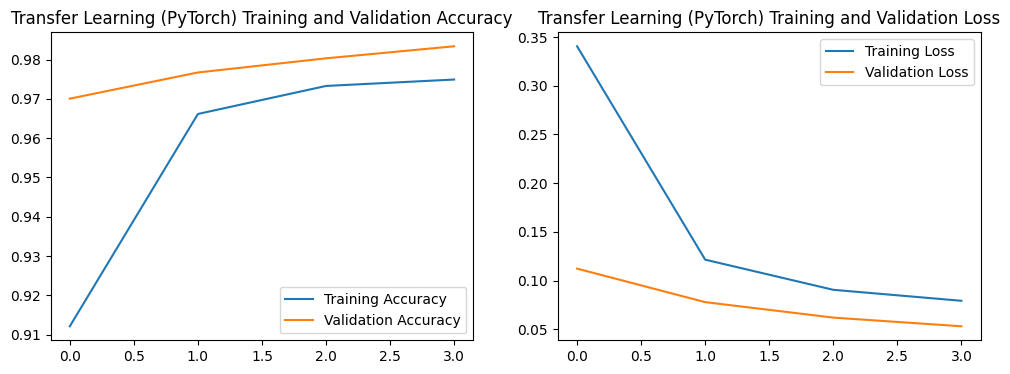


--- PyTorch Model Evaluation ---
Simple CNN:


Evaluating: 100%|██████████| 469/469 [00:56<00:00,  8.24it/s]


Validation Loss: 0.0532 Acc: 0.9834


(0.05321996340354283, tensor(0.9834, device='cuda:0', dtype=torch.float64))

In [13]:
import matplotlib.pyplot as plt
def plot_training_history_pt(history, model_name):
    """Plots training and validation accuracy and loss for PyTorch."""
    acc = history['train_acc']
    val_acc = history['val_acc']
    loss = history['train_loss']
    val_loss = history['val_loss']

    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title(f'{model_name} Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title(f'{model_name} Training and Validation Loss')
    plt.show()

# Plot histories for each model
# plot_training_history_pt(history_simple_pt, "Simple CNN (PyTorch)")
# plot_training_history_pt(history_deeper_pt, "Deeper CNN (PyTorch)")
plot_training_history_pt(history_transfer_pt, "Transfer Learning (PyTorch)")

# Evaluation on validation set
def evaluate_model_pt(model, dataloader, criterion, device):
    model.eval() # Set model to evaluate mode
    running_loss = 0.0
    running_corrects = 0

    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc="Evaluating"):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

    total_loss = running_loss / len(dataloader.dataset)
    total_acc = running_corrects.double() / len(dataloader.dataset)
    print(f"Validation Loss: {total_loss:.4f} Acc: {total_acc:.4f}")
    return total_loss, total_acc

print("\n--- PyTorch Model Evaluation ---")
print("Simple CNN:")
# evaluate_model_pt(model_simple_cnn_pt, dataloaders['val'], criterion, device)
# print("Deeper CNN:")
# evaluate_model_pt(model_deeper_cnn_pt, dataloaders['val'], criterion, device)
# print("Transfer Learning:")
evaluate_model_pt(model_transfer_pt, dataloaders['val'], criterion, device)

In [22]:
print(model_transfer_pt)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  